# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD3 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de :
- Tester l'importance de la régression
- Calculer les intervalles de confiance des coefficients de régression.
- Identifier les variables explicatives les plus importantes.


# Contexte : Tension artérielle des patients

Le jeu de données étudié dans ce TD concerne la prédiction de la tension artérielle (:BP) d'un patient mesurée en *mm* de mercure en fonction des 6 variables explicatives suivantes :

- x₁ : âge en années (:Age);
- x₂ : masse en *kg* (:Weight);
- x₃ : surface corporelle en *m²* (:BSA) ;
- x₄ : durée de l'hypertension en années (:Dur) ;
- x₅ : pouls basal en battements par minute (:Pulse) ;
- x₆ : niveau de stress de 0 à 100 (:Stress).

Le fichier *bloodpressure.csv* contient les tensions artérielles de 20 patients en plus des 6 variables explicatives.


In [1]:
# Chargement des librairies
using CSV, DataFrames, Distributions, Gadfly, Statistics, LinearAlgebra

In [2]:
data = CSV.read("bloodpressure.csv", DataFrame)
first(data,10)

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64
1,1,105,47,85.4,1.75,5.1,63,33
2,2,115,49,94.2,2.1,3.8,70,14
3,3,116,49,95.3,1.98,8.2,72,10
4,4,117,50,94.7,2.01,5.8,73,99
5,5,112,51,89.4,1.89,7.0,72,95
6,6,121,48,99.5,2.25,9.3,71,10
7,7,121,49,99.8,2.25,2.5,69,42
8,8,110,47,90.9,1.9,6.2,66,8
9,9,110,49,89.2,1.83,7.1,69,62


# Exercice 1

Dans cet exercice, on souhaite tester l'importance de la régression, c'est-à-dire vérifier si au moins une variable explicative possède un pouvoir prédictif significatif de la tension artérielle.


Pour répondre à cette question, l'importance de la régression sera testée.

In [3]:
# Variable d'intérêt
y = data.BP

# Taille d'échantillon
n = length(y)

# Matrice de structure
X = hcat(ones(n), Matrix(data[:,3:end]))

20×7 Matrix{Float64}:
 1.0  47.0   85.4  1.75   5.1  63.0  33.0
 1.0  49.0   94.2  2.1    3.8  70.0  14.0
 1.0  49.0   95.3  1.98   8.2  72.0  10.0
 1.0  50.0   94.7  2.01   5.8  73.0  99.0
 1.0  51.0   89.4  1.89   7.0  72.0  95.0
 1.0  48.0   99.5  2.25   9.3  71.0  10.0
 1.0  49.0   99.8  2.25   2.5  69.0  42.0
 1.0  47.0   90.9  1.9    6.2  66.0   8.0
 1.0  49.0   89.2  1.83   7.1  69.0  62.0
 1.0  48.0   92.7  2.07   5.6  64.0  35.0
 1.0  47.0   94.4  2.07   5.3  74.0  90.0
 1.0  49.0   94.1  1.98   5.6  71.0  21.0
 1.0  50.0   91.6  2.05  10.2  68.0  47.0
 1.0  45.0   87.1  1.92   5.6  67.0  80.0
 1.0  52.0  101.3  2.19  10.0  76.0  98.0
 1.0  46.0   94.5  1.98   7.4  69.0  95.0
 1.0  46.0   87.0  1.87   3.6  62.0  18.0
 1.0  46.0   94.5  1.9    4.3  70.0  12.0
 1.0  48.0   90.5  1.88   9.0  71.0  99.0
 1.0  56.0   95.7  2.09   7.0  75.0  99.0

## a) Calculez la variabilité totale SST

In [4]:
ȳ = mean(y)

SST = sum( (y .- ȳ).^2 )

560.0

In [5]:
# Vous devriez obtenir SST = 560

## b) Calculez la variabilité expliquée (SSR) et la variabilité résiduelle (SSE)

Pour tester l'importance de la régression, on utilise toutes les variables explicatives.

In [6]:
# Estimation des coefficients de régression
β̂ = X\y

# Projection des points sur l'hyperplan de régression
ŷ = X*β̂

# Calcul des erreurs observées
e = y - ŷ

# Calcul de la variabilité résiduelle (erreur)
SSE = sum( e.^2 )

# Calcul de la variabilité expliquée par la régression
SSR = SST - SSE

557.8441422634112

In [7]:
# Vous devriez obtenir SSR = 557.8 et SSE = 2.16.

## c) Calculez la statistique observée permettant de tester l'importance de la régression

La statistique du test est égale à :

$$F = \frac{(n-p-1)}{p} \frac{SS_R}{SS_E}.$$

In [8]:
p = size(X,2) - 1

F₀ = (n-p-1)/p * SSR/SSE

560.6410329049922

In [9]:
# Vous devriez obtenir Fₒ = 560.6.

## d) Illustrez la distribution de la statistique de test lorsque l'hypothèse nulle est vraie.

Lorsque l'hypothèse nulle est vraie, on a que 

$$F \sim \mathcal{F}isher(p, n-p-1).$$

**Suggestion :** Utilisez l'objet *FDist* de la librairie *Distributions.jl* pour appliquer la méthode `pdf()` donnant la densité. 

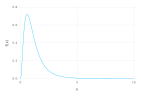

In [10]:
# Construction de l'objet Distribution
F = FDist(p, n-p-1)

# Affichage de la densité avec Gadfly
plot(x->pdf(F, x), 0, 10)

## e) Calculez la région critique pour le rejet de l'hypothèse nulle

Utilisez le risque α = 5%

**Suggestion :** Utilisez la méthode `quantile()` pour identifier le point de la région critique. 

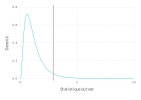

In [11]:
# Niveau de risque
α = .05

# Calcul du seuil critique du test
c = quantile(F, 1-α)

# Affichage de la région critique
d = layer(x->pdf(F, x), 0, 10)
rc = layer(xintercept =[c], Geom.vline(color="red"))
plot(d,rc, Guide.xlabel("Statistique du test"), Guide.ylabel("Densité"))

In [12]:
# Vous devriez obtenir seuil = 2.915

## f) Quelle est la décision du test

Décidez si vous rejetez ou non l'hypothèse nulle.

In [13]:
if F₀ > c
    println("On rejette l'hypothèse nulle.")
else
    println("On ne rejette pas l'hypothèse nulle.")
end

On rejette l'hypothèse nulle.


In [14]:
# Vous devriez rejeter l'hypothèse nulle.

## g) Calculez le seuil observé du test (la valeur-p)

La valeur-p est la probabilité d'observer une statistique plus extrême que celle obtenue.

**Suggestion :** Utilisez la méthode `cdf()`. 

In [15]:
# Probabilité d'observer une statistique plus extrême que celle observée
vp = 1-cdf(F, F₀)

# La statistique observée est extrême. 
# Alors la probabilité d'observer une statistique plus extrême est très petite.


if vp < α
    println("On rejette l'hypothèse nulle.")
else
    println("On ne rejette pas l'hypothèse nulle.")
end
    

On rejette l'hypothèse nulle.


In [16]:
# Vous devriez obtenir valeurp = 6.44e-15

# Exercice 2

## a) Estimez la variance de l'erreur.

En utilisant toutes les variables explicatives.

In [17]:
σ̂² = SSE / (n-p-1)

0.16583521050683453

In [18]:
# Vous devriez obtenir σ̂² = 0.1658

## b) Calculez les intervalles de confiance à 95 % pour β

In [19]:
# Niveau de confiance
α = .05

# Calcul de l'inverse de la matrice (X'X) (ok dans un contexte académique)
V = inv(X'X)

# Extraction de la diagonale
v = diag(V)

# Calcul du quantile d'ordre (1-α/2) de la loi de Student à (n-p-1) degrés de liberté
q = quantile(TDist(n-p-1), 1-α/2)

# Intervalles de confiance à 95%
hcat(β̂ - q*sqrt.(σ̂²*v), β̂ + q*sqrt.(σ̂²*v))

7×2 Matrix{Float64}:
 -18.3938      -7.34717
   0.596093     0.810426
   0.833582     1.10626
   0.362783     7.1902
  -0.0362684    0.173035
  -0.195979     0.0270097
  -0.00180033   0.0129433

In [20]:
# Façon numériquement stable d'inverser la matrice (X'X)

using LinearAlgebra
F = qr(X)
R = UpperTriangular(F.R)

R⁻¹ = inv(R)

V = R⁻¹ * (R⁻¹)'

# Ici, il n'y a pas vraiment d'instabilité numérique
V ≈ inv(X'X)

true

In [21]:
# Vous devriez obtenir β₁ ∈ [0.596 , 0.81], etc.

## c) Quelles variables semblent non significatives ?

:Dur, :Pulse et :Stress semblent non significatives car 0 est inclus dans l'intervalle de confiance.

# Exercice 3

Pour identifier la variable explicative la plus importante, on peut estimer tous les modèles de régression linéaire simple et comparer les coefficients de détermination. Le modèle ayant le coefficient de détermination le plus élevé correspond à la variable explicative la plus importante.

Une autre façon de faire pour ordonner l'importance des variables explicatives consiste à comparer le ratio signal sur bruit des coefficients de régression. Le score-Z permet de calculer ce ratio :

$$ \operatorname{Z-score}_j  = \frac{β̂ⱼ}{\sqrt{σ̂² \times v_{j+1}}}.$$

La variable la plus importante est celle qui possède le plus grand score-*Z* en valeur absolue.

Calculez les score-Z de chacune des variables explicatives pour déterminer celle qui explique le mieux la tension artérielle.

In [22]:
Z = β̂./sqrt.(σ̂² * diag(V))

7-element Vector{Float64}:
 -5.034117547970237
 14.176957600983751
 15.369093610062126
  2.38995597608855
  1.4116626166934485
 -1.63701525287501
  1.6327697339782024

In [23]:
# Vous devriez obtenir que le poids est la variable la plus importante avec un score-Z de 15.4.

# Exercice 4

Encore une autre façon pour ordonner l'importance des variables explicatives consiste à comparer les estimations des coefficients de régression lorsque les variables explicatives et la variable d'intérêt sont d'abord standardisées.

Lorsque toutes les variables explicatives sont standardisées, elles sont donc sur la même échelle et les coefficients de régression peuvent être directement comparés. En l'occurrence, un coefficient plus grand implique un effet plus grand.

**Remarque :** Lorsque toutes les variables sont standardisées, l'ordonnée à l'origine n'est plus nécessaire. Pour le comprendre, regarder l'expression de β̂₀ dans la régression linéaire simple.

Calculez les coefficients de régression en utilisant les variables standardisées. Identifiez la variable explicative la plus importante.

In [24]:
# Variable d'intérêt standardisée
ỹ = (y .- ȳ)./std(y)

# Calcul de la moyenne de chacune des colonnes
m = mean(X, dims=1)

# Calcul de l'écart-type de chacune des colonnes
s = std(X, dims=1)

# Standardisation des variables explicatives
X̃ = (X .- m)./s

# On retire la colonne de 1 car l'ordonnée. à l'origine n'est plus nécessaire si on standardise.
X̃ = X̃[:, 2:end]

20×6 Matrix{Float64}:
 -0.639865  -1.79049    -1.81709    -0.619967  -1.73545   -0.548719
  0.159966   0.258446    0.747351   -1.22595    0.105179  -1.06104
  0.159966   0.514563   -0.131885    0.825069   0.631073  -1.16889
  0.559882   0.374863    0.0879236  -0.293668   0.89402    1.23091
  0.959798  -0.859158   -0.791312    0.2657     0.631073   1.12305
 -0.239949   1.49247     1.8464      1.33782    0.368126  -1.16889
  0.159966   1.56232     1.8464     -1.83193   -0.157768  -0.306043
 -0.639865  -0.509906   -0.718043   -0.107212  -0.94661   -1.22282
  0.159966  -0.905724   -1.23093     0.312314  -0.157768   0.233239
 -0.239949  -0.0908053   0.527542   -0.386897  -1.4725    -0.494791
 -0.639865   0.305013    0.527542   -0.526739   1.15697    0.988234
  0.159966   0.235162   -0.131885   -0.386897   0.368126  -0.872289
  0.559882  -0.346923    0.381002    1.75735   -0.420715  -0.171222
 -1.4397    -1.39468    -0.571503   -0.386897  -0.683663   0.718593
  1.35971    1.91157     1.40678

In [25]:
β̂ = X̃\ỹ

6-element Vector{Float64}:
  0.32391402232053346
  0.7673123403049342
  0.09493951167490457
  0.027021809842352223
 -0.0591823695208713
  0.03806002164026938

In [26]:
# Vous devriez obtenir que le poids est la variable la plus importante avec β̂₂ = 0.767.